# Statistics of the NST dataset

In [134]:
# Imports
from src.utils.file_management import ROOT_PATH, load_subtitles_from_nst_sample, load_nst_sample, subtitles_file_exists, load_subtitles, write_subtitles_file, stats_file_exists, load_stats_file, write_stats_file
from src.utils.tables_and_plots import create_stats_table
import os
import statistics
import matplotlib.pyplot as plt
from tabulate import tabulate
import random

from textPrep.preprocessing_pipeline import (
    Preprocess,
    RemoveSubtitleMetadata)

from textPrep.preprocessing_pipeline.NextGen import NextGen

NST_FULL_SIZE = "FULL"
NST_SAMPLE_SIZE = 1000

In [62]:
# Load NST sample, from original NST folder and sample file

file_path_full = os.path.join(ROOT_PATH, r"nst_sample", f"nst_{NST_FULL_SIZE}.csv")
file_path_sample = os.path.join(ROOT_PATH, r"nst_sample", f"nst_{NST_SAMPLE_SIZE}.csv")

nst_full = load_nst_sample(file_path_full)
nst_sample = load_nst_sample(file_path_sample)

In [3]:
def harmonic_mean(coh, div):
    return ((1+coh)+2*div)/4

In [10]:
harmonic_mean(0.909,0.512)

0.73325

In [12]:
harmonic_mean(0.563,1.0)

0.8907499999999999

In [73]:
nst_full_lengths = [len(file) for file in nst_full.values()]
nst_sample_lengths = [len(file) for file in nst_sample.values()]

In [74]:
print("Statistics full NST dataset:")
print("Number of files:", len(nst_full))
print("Average file length:", statistics.mean(nst_full_lengths))
print("Median file length:", statistics.median(nst_full_lengths))
print("Min file length:", min(nst_full_lengths))
print("Max file length:", max(nst_full_lengths))

print("\nStatistics sample:")
print("Number of files:", len(nst_sample))
print("Average file length:", statistics.mean(nst_sample_lengths))
print("Median file length:", statistics.median(nst_sample_lengths))
print("Min file length:", min(nst_sample_lengths))
print("Max file length:", max(nst_sample_lengths))

Statistics full NST dataset:
Number of files: 14550
Average file length: 203.93079037800686
Median file length: 155.0
Min file length: 2
Max file length: 2146

Statistics sample:
Number of files: 999
Average file length: 199.6096096096096
Median file length: 149
Min file length: 8
Max file length: 1814


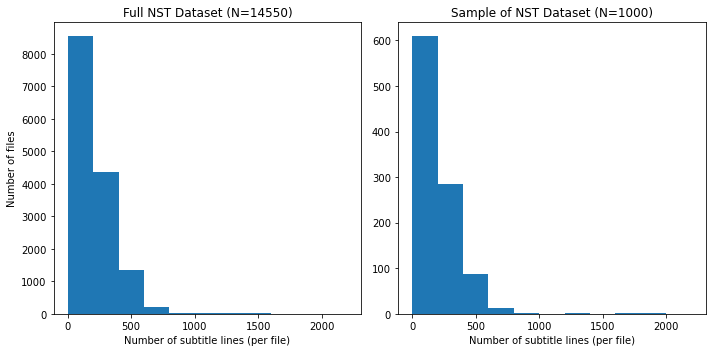

In [75]:
column_ranges = [i * 200 for i in range(0, 12)]
titles = ["Full NST Dataset (N=14550)", "Sample of NST Dataset (N=1000)"]
datasets = [nst_full_lengths, nst_sample_lengths]

fig = plt.figure(figsize=(10, 5))
for i in range(len(datasets)):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.set_title(titles[i])
    ax.set_xlabel("Number of subtitle lines (per file)")
    if i == 0:
        ax.set_ylabel("Number of files")
    plt.hist(datasets[i], bins=column_ranges)
fig.tight_layout()
plt.show()

In [76]:
# plt.boxplot(nst_lengths)

In [77]:
# Load unprocessed NST and NST sample to use for statistical analysis
nst_subtitles_full = load_subtitles_from_nst_sample(NST_FULL_SIZE)
nst_subtitles_sample = load_subtitles_from_nst_sample(NST_SAMPLE_SIZE)

In [78]:
# Token stats of both datasets

folder_path = r"preliminary_experiment/preprocessed_data/"
file_name_full = f"pe_{NST_FULL_SIZE}"
file_name_sample = f"pe_{NST_SAMPLE_SIZE}"

table_stats_full = None
table_stats_sample = None

if stats_file_exists(folder_path, file_name_full):
    table_stats_full = list(load_stats_file(folder_path, file_name_full).items())
else:
    table_stats_full = create_stats_table(list(nst_subtitles_full.values()))
    write_stats_file(folder_path, file_name_full, table_stats_full)

if stats_file_exists(folder_path, file_name_sample):
    table_stats_sample = list(load_stats_file(folder_path, file_name_sample).items())
else:
    table_stats_sample = create_stats_table(list(nst_subtitles_sample.values()))
    write_stats_file(folder_path, file_name_sample, table_stats_sample)

print(tabulate(table_stats_full, headers=["Stat (Full NST)", "Value"]))
print()
print(tabulate(table_stats_sample, headers=["Stat (Sample)", "Value"]))

Stat (Full NST)                   Value
---------------------  ----------------
dataset_size            14550
vocab_size             872561
total_tokens                2.72116e+07
avg_token_freq             31.1859
avg_token_per_doc        1870.21
avg_stopwords_per_doc     897.908

Stat (Sample)                     Value
---------------------  ----------------
dataset_size              999
vocab_size             157221
total_tokens                1.82958e+06
avg_token_freq             11.637
avg_token_per_doc        1831.41
avg_stopwords_per_doc     881.47


In [79]:
# Initialize the textPrep pipeline
pipeline = Preprocess()

# Removing technical metadata from subtitles
rsm = RemoveSubtitleMetadata()

# Add rules to the pipeline (the stringified rule makes it easy to save the pipeline details)
pipeline.document_methods = [(rsm.remove_subtitle_metadata, str(rsm),)]

# Initialize the pipeline runner
runner = NextGen()

In [80]:
# Preprocess the data with the given rules

file_name_full_metadata_removed = f"pe_{NST_FULL_SIZE}_metadata_removed"
file_name_sample_metadata_removed = f"pe_{NST_SAMPLE_SIZE}_metadata_removed"

nst_subtitles_full_metadata_removed = None
nst_subtitles_sample_metadata_removed = None

if subtitles_file_exists(folder_path, file_name_full_metadata_removed):
    nst_subtitles_full_metadata_removed = load_subtitles(folder_path, file_name_full_metadata_removed)
else:
    preprocessed_full_data = runner.full_preprocess(list(nst_subtitles_full.values()), pipeline, ngram_min_freq=-1)
    nst_subtitles_full_preprocessed = dict(zip(nst_subtitles_full.keys(), preprocessed_full_data))
    nst_subtitles_full_metadata_removed = {}
    for (program_id, subtitles) in nst_subtitles_full_preprocessed.items():
            nst_subtitles_full_metadata_removed[program_id] = " ".join(subtitles).split()
    write_subtitles_file(folder_path, file_name_full_metadata_removed, nst_subtitles_full_metadata_removed)

if subtitles_file_exists(folder_path, file_name_sample_metadata_removed):
    nst_subtitles_sample_metadata_removed = load_subtitles(folder_path, file_name_sample_metadata_removed)
else:
    preprocessed_sample_data = runner.full_preprocess(list(nst_subtitles_sample.values()), pipeline, ngram_min_freq=-1)
    nst_subtitles_sample_preprocessed = dict(zip(nst_subtitles_sample.keys(), preprocessed_sample_data))
    nst_subtitles_sample_metadata_removed = {}
    for (program_id, subtitles) in nst_subtitles_sample_preprocessed.items():
            nst_subtitles_sample_metadata_removed[program_id] = " ".join(subtitles).split()
    write_subtitles_file(folder_path, file_name_sample_metadata_removed, nst_subtitles_sample_metadata_removed)

In [83]:
example_program_id = random.choice(list(nst_subtitles_sample.keys()))
example_program_slice = 10
print(nst_subtitles_full[example_program_id][:example_program_slice])
print(nst_subtitles_full_metadata_removed[example_program_id][:example_program_slice])

['{\\an1}.', '{\\an1}Opptak', 'av', 'simultanteksting', '{\\an1}Kreftpasienter', 'må', 'vente', 'opptil', 'sju', 'timer']
['.', 'Kreftpasienter', 'må', 'vente', 'opptil', 'sju', 'timer', 'på', 'drosje', 'etter']


In [124]:
# Stats after removing metadata

table_stats_full_metadata_removed = None
table_stats_sample_metadata_removed = None

if stats_file_exists(folder_path, file_name_full_metadata_removed):
    table_stats_full_metadata_removed = list(load_stats_file(folder_path, file_name_full_metadata_removed).items())
else:
    table_stats_full_metadata_removed = create_stats_table(list(nst_subtitles_full_metadata_removed.values()))
    write_stats_file(folder_path, file_name_full_metadata_removed, table_stats_full_metadata_removed)

if stats_file_exists(folder_path, file_name_sample_metadata_removed):
    table_stats_sample_metadata_removed = list(load_stats_file(folder_path, file_name_sample_metadata_removed).items())
else:
    table_stats_sample_metadata_removed = create_stats_table(list(nst_subtitles_sample_metadata_removed.values()))
    write_stats_file(folder_path, file_name_sample_metadata_removed, table_stats_sample_metadata_removed)

print(tabulate(table_stats_full_metadata_removed, headers=["Stat (Full NST)", "Value"]))
print(tabulate(table_stats_sample_metadata_removed, headers=["Stat (Sample)", "Value"]))

Stat (Full NST)                  Value
---------------------  ---------------
dataset_size            14550
vocab_size             821625
total_tokens                2.7143e+07
avg_token_freq             33.0357
avg_token_per_doc        1865.5
avg_stopwords_per_doc     897.441
Stat (Sample)                     Value
---------------------  ----------------
dataset_size              999
vocab_size             149975
total_tokens                1.82517e+06
avg_token_freq             12.1698
avg_token_per_doc        1826.99
avg_stopwords_per_doc     880.987


In [145]:
def print_stats_table(title, stats):
    print(title, end=" ")
    for stat in stats:
        if stat[1].isdigit():
            print(f"& {int(stat[1]):}", end=" ")
        else:
            print(f"& {float(stat[1]):.2f}", end=" ")
    print(r"\\ \hline")

In [146]:
print_stats_table(r"Normal", table_stats_full)
print_stats_table(r"Preproc.", table_stats_full_metadata_removed)

Normal & 14550 & 872561 & 27211612 & 31.19 & 1870.21 & 897.91 \\ \hline
Preproc. & 14550 & 821625 & 27142971 & 33.04 & 1865.50 & 897.44 \\ \hline


In [147]:
print_stats_table(r"NST", table_stats_full_metadata_removed)
print_stats_table(r"Sample", table_stats_sample_metadata_removed)

NST & 14550 & 821625 & 27142971 & 33.04 & 1865.50 & 897.44 \\ \hline
Sample & 999 & 149975 & 1825168 & 12.17 & 1826.99 & 880.99 \\ \hline
